In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Problem 6.0   
> The fit value of Tm is 331.9 K which is in line with visual inspection of the data (where the peak is). The fit value of $\Delta$C$_p$ is 6.29 KJ/mol K which is also in line with visual inspection of the difference between the two baselines. The fit value of $\Delta$$\overline{H_m}$ is 396.2 KJ/mol which is in line with expectations as well as the heat capacity should be positive for the endothermic process of temperature unfolding and it is about what Dr. Barrick told us to expect for an unfolding transition with a range of around 15 K

In [2]:
df = pd.read_csv('./DSC_data_scaled.txt', header=None, sep=' ')
Temps = df[0]
dCp = df[1]




def differential_heat_capacity(T, Cp_d, DeltaCp, Tm, DeltaHm):
    R = 8.3145e-3 #IDG Contant in KJ/mol K
    Delta_G = DeltaHm - T*(DeltaHm/Tm)
    K = np.exp(-(Delta_G / (R * T)))
    fN = K / (1 + K)
    fD = 1 / (1 + K)
    
    Cp_pwa = Cp_d + fN * DeltaCp
    Cp_excess = fN*fD * DeltaHm**2 / (R*T**2)
    
    differential_Cp = Cp_pwa + Cp_excess
    
    return differential_Cp


guesses = [11, 7, 332.5, 400]
popt, pcov = curve_fit(differential_heat_capacity, Temps, dCp, guesses)
print(['Cp_d', 'DeltaCp', 'Tm', 'DeltaHm'], '=', popt)

['Cp_d', 'DeltaCp', 'Tm', 'DeltaHm'] = [  4.17179616   6.28907394 331.9146664  396.23614068]


### Problem 6.1    
> The midpoint of the C$_{p,PWA}$ curve corresponds to the peak of the fit curve which both occur at the Tm (331.9 K)

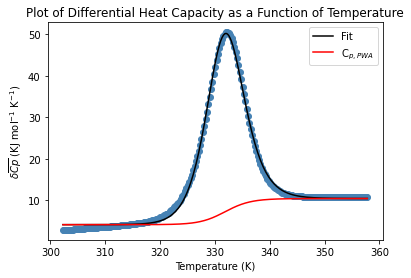

In [3]:

def pwa(T, Cp_d, DeltaCp, Tm, DeltaHm):
    R = 8.3145e-3 #IDG Contant in KJ/mol K
    Delta_G = DeltaHm - T*(DeltaHm/Tm)
    K = np.exp(-(Delta_G / (R * T)))
    fN = K / (1 + K)
    fD = 1 / (1 + K)
    
    Cp_pwa = Cp_d + fN * DeltaCp
    Cp_excess = fN*fD * DeltaHm**2 / (R*T**2)
    
    differential_Cp = Cp_pwa #+ Cp_excess
    
    return differential_Cp

pwas = pwa(Temps, *popt)

plt.plot(Temps, dCp, 'o', color='steelblue')
plt.plot(Temps, differential_heat_capacity(Temps, *popt) ,'k', label='Fit')
plt.plot(Temps, pwas, 'r',label='C$_{p, PWA}$')

plt.title("Plot of Differential Heat Capacity as a Function of Temperature")
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('$\delta$$\overline{Cp}$ (KJ mol$^{-1}$ K$^{-1}$)');

### Problem 6.2
> The simple riemann sum function below returns an area of 396.2 KJ / mol. This is the same value as obtained for $\Delta$$\overline{H_m}$ from the curve fit!

In [4]:
def riemann_sum(a, b, curve1, curve2, bin_width):
    '''
    Calculates a simple Riemann sum by finding the area as the sum of area of rectangles with height curve2 - curve1 and width bin_width from a to b. 
    '''
    sum = 0
    x = np.arange(a, b + bin_width, bin_width)
    
    vals1 = curve1(x, *popt)
    vals2 = curve2(x, *popt)
    for i,j in enumerate(x):
        h = vals2[i] - vals1[i]
        sum += h * bin_width
    return sum
    
area = riemann_sum(Temps[0], Temps[len(Temps)-1], pwa, differential_heat_capacity, 0.01)
print('Area:', area)

Area: 396.2236863897687


### Problem 6.6   
> The plot generated below shows that the log of the number of ways is maximized when the $\mathbb{N_i}$'s are all equal because the log(number of ways) is just a simple transformation applied to the trinomial distribution. This plot shows non-integer values for $\mathbb{N_2}$ and $\mathbb{N_3}$, but since there really only makes sense for the number of a particular microstate to be an integer value, the maximum number of arrangements is found when ($\mathbb{N_1}$, $\mathbb{N_2}$, $\mathbb{N_3}$) = (6,7,7) or (7,6,7) or (7,7,6)

<ipython-input-5-4909fb7d85cc>:28: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))


Integer Maxima: 
21.921346568937103
21.921346568937103
21.921346568937103


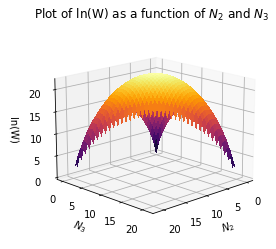

In [5]:
def log_number_of_ways(N2, N3):
    A = 20
    N1 = A - N2 - N3
    first = 0 if N1 <= 0 else N1 * np.log(N1) 
    second = 0 if  N2 <= 0 else N2 * np.log(N2)
    third = 0 if N3 <= 0 else N3 * np.log(N3)
    out = A*np.log(A) - ( first + second + third) if N1+N2+N3 <= A and N1 >= 0 else np.nan
    return out

N3 = N2 = np.arange(0, 21, .1)
X, Y = np.meshgrid(N2, N3)

out = []
for i,j in enumerate(X):
    row = []
    for k,l in enumerate(j):
        row.append(log_number_of_ways(l, Y[i][k]))
    out.append(row)

Z = np.array(out)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('$N_2$')
ax.set_ylabel('$N_3$')
ax.set_zlabel('ln(W)')
ax.set_title('Plot of ln(W) as a function of $N_2$ and $N_3$')
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))
ax.view_init(16, 46)


print("Integer Maxima: ")
print(log_number_of_ways(6,7))
print(log_number_of_ways(7,7))
print(log_number_of_ways(7,6))

### Problem 6.7

<ipython-input-12-7bdfbf654140>:7: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))


Maximum at (N1,N2,N3) = (12, 4, 4) where ln(W) =  19.005410784664683


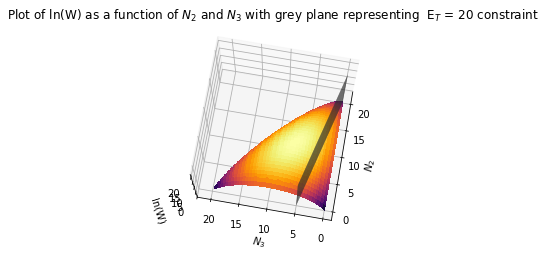

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('$N_2$')
ax.set_ylabel('$N_3$')
ax.set_zlabel('ln(W)')
ax.set_title('Plot of ln(W) as a function of $N_2$ and $N_3$ with grey plane representing  E$_T$ = 20 constraint')
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))

zs = ys = np.arange(0, 21, .1)

B, Q = np.meshgrid(ys, zs)
A = 20 - 4*B

A[A<0] = np.nan

surf2 = ax.plot_surface(A, B, Q, color='grey')
ax.view_init(75, -170)
print('Maximum at (N1,N2,N3) = (12, 4, 4) where ln(W) = ', log_number_of_ways(4, 4))
